In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, re
import pathlib
import tensorflow as tf
from tensorflow import keras
import cv2
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data_path = os.getenv('HOME')+'/aiffel/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1001


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


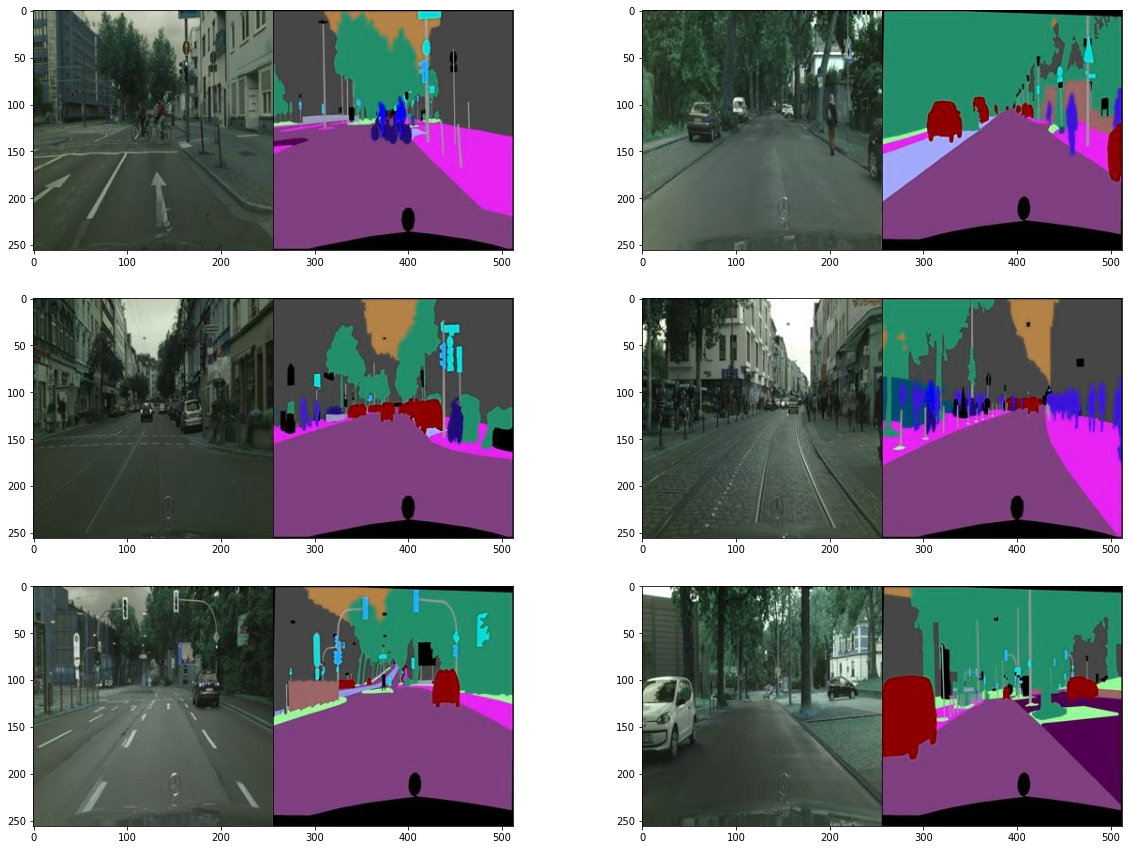

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 256, 3)
(256, 256, 3)


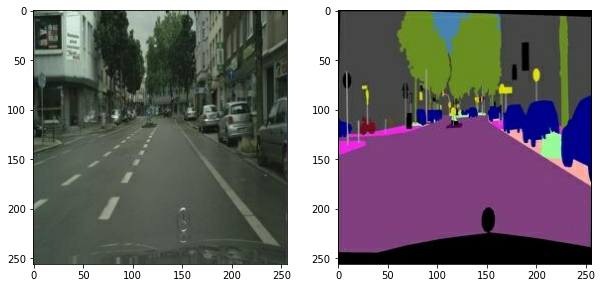

In [5]:
# data와 label 붙어있는 것 떼서 (256,512,3)->(256,256,3) 만들기

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

print(denormalize(sketch).shape)
print(denormalize(colored).shape)

# 1. Augmentation

0. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
1. 의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
2. 의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
3. 의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
4. 의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
5. 의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)     # 0
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])         # 1
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # 2
    
    out = image.random_flip_left_right(out)             # 3
    out = image.random_flip_up_down(out)                # 4
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)                # 5
    
    return out[...,:3], out[...,3:]   


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


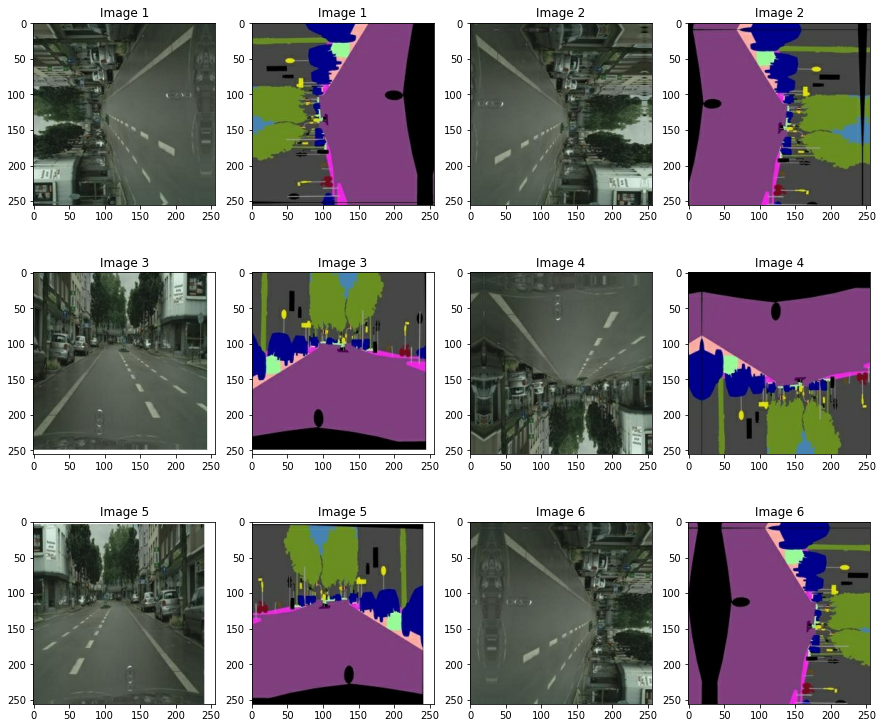

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

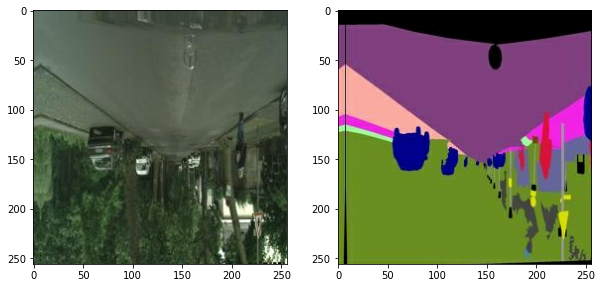

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)      # 1개만 take해서 보자
sample = list(sample.as_numpy_iterator())  # sample을 np iterator로 변경시켜 list로 바꿈. 앞에서는 float로 cast하여 바꿨음.
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5   # 127.5로 rescaling.

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. Generator

> # Encoder

- Ck : Convolution - BatchNorm - ReLU
- CDK : Conv -BatchNorm - Dropout(0.5) - ReLU
- conv : 4 * 4, stride=2 (Encoder,discrimator에서는 downsampling, decoder에서는 upsampling)

- Encoder : (ALL C)64-128-256-512-512-512-512-512 
    - 처음 64에는 batchnorm 안하고, 모두 Leaky ReLU with slope 0.2
- Decoder : CD512-CD512-CD512- C512-C256-C128-C64(Tahn)
    - 모두 그냥 ReLU

In [9]:
# 1. layer 구조블럭만들기 : Conv - batchnorm - LeakyRelu

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:             # 뒤에서 use_bn이 true면 batchnorm 해줘
            x = self.batchnorm(x)   # 처음 64는 use_bn이 false로 들어와서 batch 안할꺼임.
        return self.lrelu(x)
    
# 2. 구조블럭으로 전체 구조 만들기

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False)) # iter 0인 처음 64는 batch 안해줘야해서.
            else:
                self.blocks.append(EncodeBlock(f)) # except for the first 64,
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

> # Decoder

- Ck : Convolution - BatchNorm - ReLU
- CDK : Conv -BatchNorm - Dropout(0.5) - ReLU
- conv : 4 * 4, stride=2 (Encoder,discrimator에서는 downsampling, decoder에서는 upsampling)

- Encoder : (ALL C)64-128-256-512-512-512-512-512 
    - 처음 64에는 batchnorm 안하고, 모두 Leaky ReLU with slope 0.2
- Decoder : CD512-CD512-CD512- C512-C256-C128-C64(Tahn)
    - 모두 그냥 ReLU

In [10]:
# 1. 구조블럭 만들고
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False) 
        # 인코더와 반대로 차원 늘려야해서.
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

# 2. 구조블럭으로 전체 만들기    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:  # 4번째 512 부터는 CD 아니고 C라서 dropout 하면 안됨
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

> # U-net st. Generator

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    # 여기가 다른 부분
    def call(self, x):
        features = [] # skip connection을 위해 feature이라는 리스트를 만들어 
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)  # encoder의 output들을 저장해놓음.
        
        features = features[:-1]  # 제일 마지막 항목은 어차피 decoder로 자동 넘어가므로 뺌
        
        
        # encoder layer들의 역순이 decoder라서, ::-1 하면 역순이 되니까
        # 이 상태로 feature 리스트와 x를 concat하여 함께 decoder input으로 전달
        
        for block, feat in zip(self.decode_blocks, features[::-1]):  
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

# 3. Discriminator

- Ck : Convolution - BatchNorm - ReLU
- CDK : Conv -BatchNorm - Dropout(0.5) - ReLU
- conv : 4 * 4, stride=2 
- Discriminator : (70x70) C64-C128-C256-C512(sigmoid)
    - 처음 64에는 batchnorm 안하고, 모두 Leaky ReLU with slope 0.2

-----------------------------------------------
- Encoder : (ALL C)64-128-256-512-512-512-512-512 
    - 처음 64에는 batchnorm 안하고, 모두 Leaky ReLU with slope 0.2
- Decoder : CD512-CD512-CD512- C512-C256-C128-C64(Tahn)
    - 모두 그냥 ReLU

In [12]:
# 1. 블럭만들기

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 
    
# 2. 구조전체 만들기
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

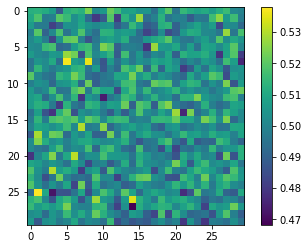

In [13]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 4. Loss Function

In [14]:
# 1. mae로 L1을 주고,
# 2. from_logits=False로 loss 함수 통과 전 숫자화하여 sigmoid 먼저 통과하지 못하게.
# 3. 다중 분류의 경우 보통 False로 사용

from tensorflow.keras import losses,optimizers

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# G의 loss로는 생성된 것 중 가짜에대한 D의 출력만 필요하여 fake_disc만. real_disc 필요없음.
# fake_disc : discriminator의 판별 결과 output
def get_gene_loss(fake_output, real_output, fake_disc): 
    l1_loss = mae(real_output, fake_output) # L1 loss 
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc) # generator 결과를 binary해서 output으로 
    return gene_loss, l1_loss

# D의 loss로는 생상한 것 중에서 가짜에 대한 D의 출력과 진짜에 대한 D의 출력 모두를 필요
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


# learning rate
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정

In [15]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


# 5. Model Training

In [17]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.5994                     
L1_loss:0.2513                     
Discriminator_loss:0.8347

EPOCH[1] - STEP[100]                     
Generator_loss:1.5242                     
L1_loss:0.2878                     
Discriminator_loss:0.5993

EPOCH[1] - STEP[150]                     
Generator_loss:2.3888                     
L1_loss:0.2633                     
Discriminator_loss:0.6708

EPOCH[1] - STEP[200]                     
Generator_loss:2.1911                     
L1_loss:0.2120                     
Discriminator_loss:0.8044

EPOCH[1] - STEP[250]                     
Generator_loss:2.5814                     
L1_loss:0.2670                     
Discriminator_loss:0.2864

EPOCH[2] - STEP[50]                     
Generator_loss:1.9693                     
L1_loss:0.2575                     
Discriminator_loss:0.6658

EPOCH[2] - STEP[100]                     
Generator_loss:1.7117                     
L1_loss:0.2368               

# 6. 결과 확인

In [23]:
val_path = os.getenv('HOME')+'/aiffel/cityscapes/val/'
print("number of val examples :", len(os.listdir(val_path)))

number of val examples : 5


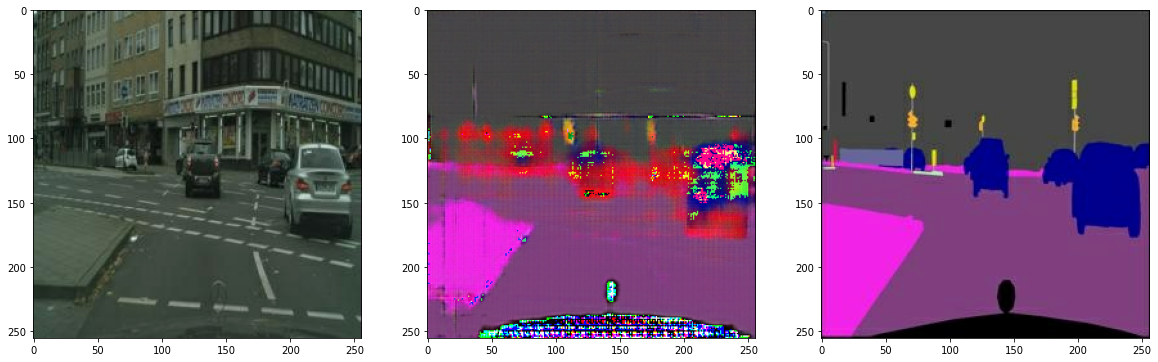

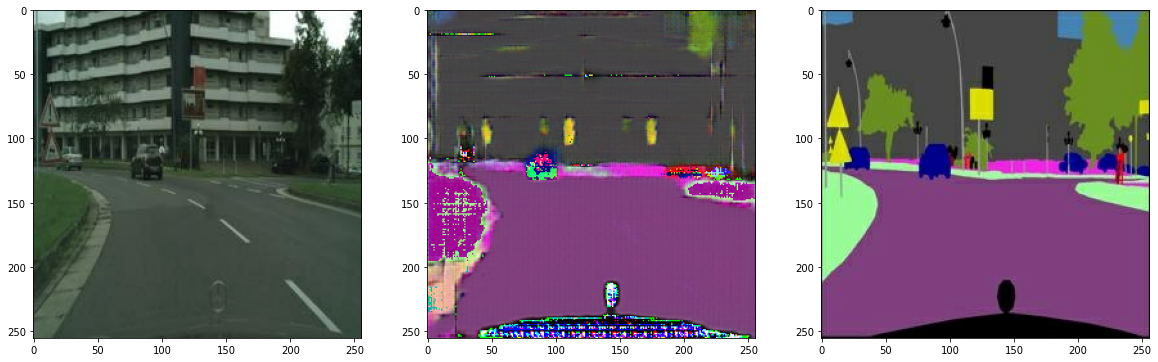

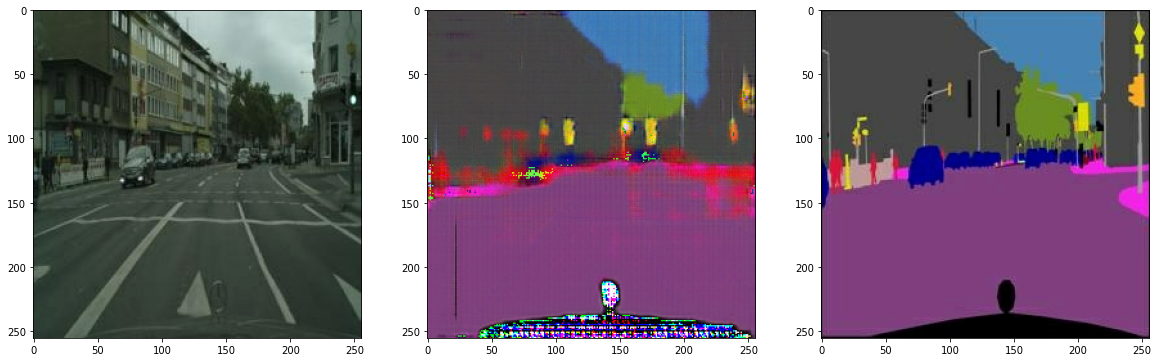

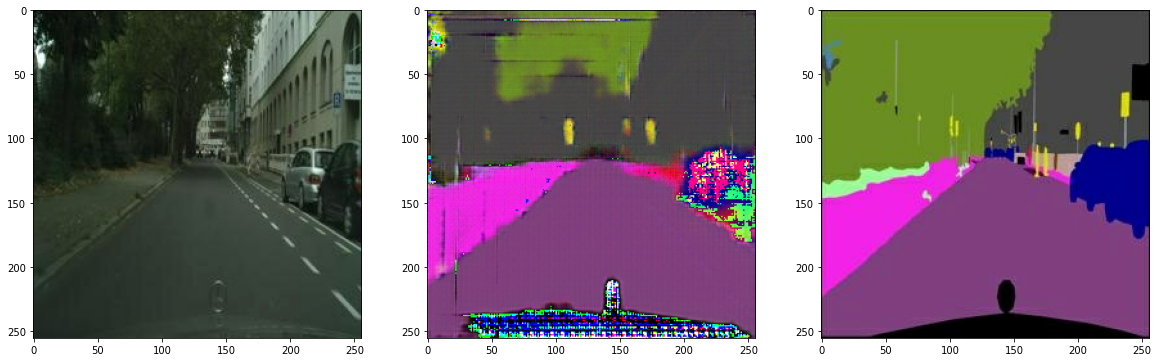

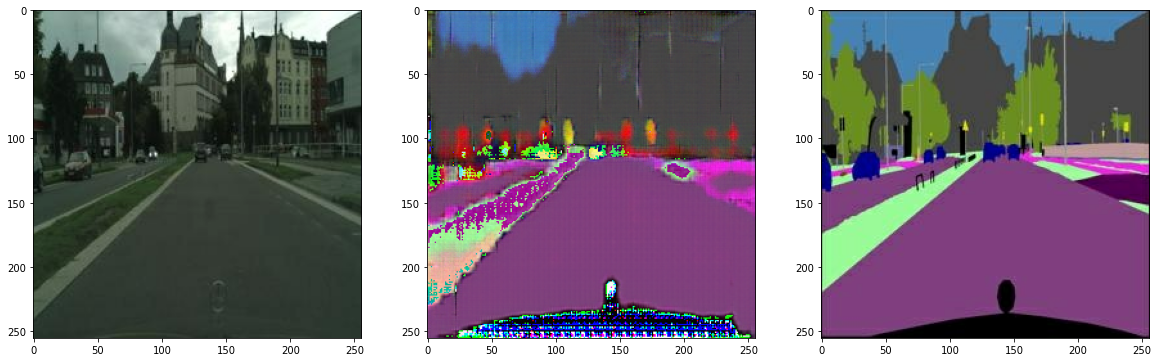

In [24]:
test_ind = 1

for test_ind in range(5):
    f = data_path + os.listdir(val_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 7. 성능 개선

augmentation 좀 더 다양하게 해서 데이터 늘려 학습해보기

1. 밝기조정 (NEW) (random_brightness)
2. 채도조정 (NEW) (random_saturation)
3. 색조조정 (NEW) (random_hue)


In [62]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])

    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    out = image.random_brightness(out, max_delta=0.1)
    out = image.random_contrast(out, lower=0.5, upper=1.5)

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[..., :3], out[..., 3:]


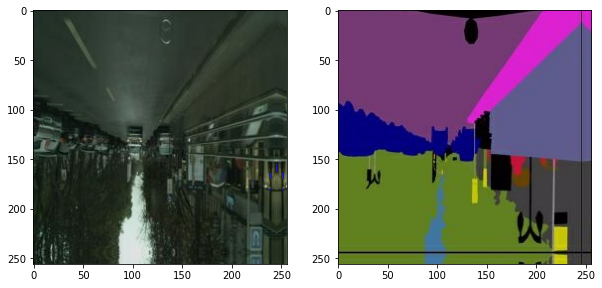

In [63]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)      # 1개만 take해서 보자
sample = list(sample.as_numpy_iterator())  # sample을 np iterator로 변경시켜 list로 바꿈. 앞에서는 float로 cast하여 바꿨음.
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5   # 127.5로 rescaling.

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [64]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

FailedPreconditionError:  Could not find variable _AnonymousVar205. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status=Not found: Resource localhost/_AnonymousVar205/N10tensorflow3VarE does not exist.
	 [[node u_net_generator_1/encode_block_16/conv2d_26/Conv2D/ReadVariableOp (defined at tmp/ipykernel_120/711290969.py:14) ]] [Op:__inference_train_step_7525]

Function call stack:
train_step


# 회고

모델을 이해하는데 transformer 만큼 시간이 오래걸린 것 같다.
여러가지 자료를 참고하여 코드 없이 개념만은 이곳에 정리하였다.
https://kolazzing.com/entry/cGAN-Pix2pix
    
먼저 모델을 이해한 뒤에 코드를 살폈다.
줄 별로 이해하려고 꼼꼼히 주석을 달며 이해했다.

개인적으로는 노드상에 두 개의 데이터셋이 나오는데,
처음 나왔던 MNIST는 leaky relu도 쓰지 않고, 간소화된 부분이 있었음에도
언급이 없어서 왜그런가 하고 고민하는데 많은 시간을 보냈다.
하지만 이 과정에서 논문과 다른점이 어떻게 되는지 더 찾아보게 된 것 같다.

Pokemon 데이터의 코드들은 논문의 내용과 일치하여, 그 뒤로는 그냥 쭉 갔다.

---
epoch = 10은 너무 결과가 안좋아서
50번으로 수정하였다.

결과를 개선해보려고,
가장 크게 데이터셋이 1000개 밖에 없는 부분을 해결하고자 
좀 더 다양한 방법으로 augmentation해서 데이터셋을 늘리는 효과를 주고 싶었는데,
오류가 나는 부분을 해결할 시간이 모자라서 더 깔끔히 마무리를 못했다.

--- 

매번 이렇게 열심히 이해하고, 돌아서면 너무 많은 부분을 까먹어서 맘이아프다ㅠㅠ



루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
- U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.